# AI4EO Hyperview - Seeing beyond the visible

Team Eagle Eyes:

Rıdvan Salih Kuzu$^*$, Caroline Arnold$^*$, Frauke Albrecht$^*$, Roshni Kamath$^*$, Kai Konen$^*$

$^*$Helmholtz AI Artificial Intelligence Cooperation Unit, Germany

We thank Lichao Mou for helpful discussions.

## 1. INTRODUCTION

The objective of the AI4EO HYPERVIEW challenge is to predict agriculturally relevant soil parameters (K, Mg, P2O5, pH) from airborne hyperspectral images. We present a hybrid model fusing Random Forest and K-nearest neighbor regressors that exploit the average spectral
reflectance, as well as derived features such as gradients, wavelet coefficients, and Fourier transforms. The solution is computationally lightweight and improves upon the challenge baseline by 21%.

## 2. SETUP

In the following cell all modules are imported, that are needed in this notebook.

In [1]:
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing


In [3]:
# SOME CONSTANTS UTILIZED IN THE NOTEBOOK

DEBUG = False
AUGMENT_CONSTANT_RF=1
AUGMENT_CONSTANT_KNN=6
LABEL_NAMES = ["P2O5", "K", "Mg", "pH"]
LABEL_MAXS = np.array([325.0, 625.0, 400.0, 7.8])
#Y_BASE_FACT = np.array([121764.2 / 1731.0, 394876.1 / 1731.0, 275875.1 / 1731.0, 11747.67 / 1731.0]) / LABEL_MAXS

COL_IX = [0, 1, 2, 3]


## 3. DATA LOADING

In addition to loading the data in a standard way provided by original notebook, we make  pre-augmentation by loading randomly cropped 11x11 size fields, because the main performance loss is coming from this part of the data. 

In [4]:

def load_data(directory: str, gt_file_path: str, is_train=True, augment_constant: int = 0):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
        gt_file_path (str): File path for the ground truth labels (expected CVS file)
        is_train (boolean): Binary flag for setting loader for Train (TRUE) or Test (FALSE)
        augment_constant (int): number of augmentation steps to randomly crop from the larger agricultural fields
    Returns:
        [type]: Tuple of lists composed of raw field (data , mask) pairs,
                and if exists: (augmented data, augmented mask) pairs, and ground truth labels
    """
    
    datalist = []
    masklist = []
    aug_datalist = []
    aug_masklist = []
    aug_labellist = []

    if is_train:
        labels = load_gt(gt_file_path)

    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )

    if DEBUG:
        all_files = all_files[:100]
        if is_train:
            labels = labels[:100]

    for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                               .format("training" if is_train else "test")):
       # We load the data into memory as provided in the example notebook of the challenge
        with np.load(file_name) as npz:
            mask = npz["mask"]
            data = npz["data"]
            datalist.append(data)
            masklist.append(mask)
            
    # for training data we make pre-augmentation by adding some randomly cropped samples
    if is_train: 
        for i in range(augment_constant):
            for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading augmentation {} ..".format(i+1)):
                # print(file_name)
                with np.load(file_name) as npz:
                    flag = True
                    mask = npz["mask"]
                    data = npz["data"]
                    ma = np.max(data, keepdims=True)
                    sh = data.shape[1:]
                    for i in range(10): 
                        # Repeating 11x11 cropping 10 times does not mean we use all croppings:
                        # as seen in the Flag=False below at the end of the loop, 
                        # when we reach at the good crop (not coinciding to the masked area) we stop searching 
                        
                        # Randomly cropping the fields with 11x11 size, 
                        # and adding some noise to the cropped samples 
                        edge = 11  
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)
                        
                        # get crops having meaningful pixels, not zeros
                        if np.sum(mask[0, x : (x + edge), y : (y + edge)]) > 120: 
                            aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                        + np.random.uniform(-0.01, 0.01, (150, edge, edge)) * ma)
                            aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))
                            
                            flag = False #break the loop when you have a meaningful crop
                            break

                    # After having  11x11 croped sample, get another crop considering 
                    # the minimum edge length: (min_edge,min_edge)
                    if flag: 
                        max_edge = np.max(sh)
                        min_edge = np.min(sh)  # AUGMENT BY SHAPE
                        edge = min_edge  # np.random.randint(16, min_edge)
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)
                        aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                    + np.random.uniform(-0.001, 0.001, (150, edge, edge)) * ma)
                        aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))

                    aug_datalist.append(aug_data)
                    aug_masklist.append(aug_mask)
                    aug_labellist.append(
                        labels[idx, :]
                        + labels[idx, :] * np.random.uniform(-0.001, 0.001, 4)
                    )

    # do pre-augmentation only for training data
    if is_train: 
        return (datalist,
                masklist,
                labels,
                aug_datalist,
                aug_masklist,
                np.array(aug_labellist))
    else:
        return datalist, masklist


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values / LABEL_MAXS  # normalize ground-truth between 0-1
    
    return labels

In [5]:

# Please be sure that the directory and file locations are given correctly in your own system
train_data_dir = "/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/train_data"
test_data_dir = "/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/test_data"
gt_data_path = "/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/train_gt.csv"

# Loading training raw data
X_train, M_train, y_train, X_aug_train, M_aug_train, y_aug_train = load_data(train_data_dir, 
                                                                             gt_data_path, 
                                                                             is_train=True, 
                                                                             augment_constant=AUGMENT_CONSTANT_KNN)
# Loading test raw data
X_test, M_test = load_data(test_data_dir, 
                           gt_file_path=None, 
                           is_train=False)

print(f"Train data size: {len(X_train)}")
print(f"Train aug data size: {len(X_aug_train)}")
print(f"Test data size: {len(X_test)}")

Loading training data ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 1 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 2 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 3 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 4 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 5 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading augmentation 6 ..:   0%|          | 0/1732 [00:00<?, ?it/s]

Loading test data ..:   0%|          | 0/1154 [00:00<?, ?it/s]

Train data size: 1732
Train aug data size: 10392
Test data size: 1154


## 4. PREPROCESSING THE LOADED DATA

We have multiple preprocessing techniques to extract features before training in the function below:

* Wavelet Transform
* Fast Fourier Transform
* Singular Value Decomposition
* First, Second and Third Derivative of the Original Data
* and some combinations of the methods above 

(For more information about the feature selection, you can look at the attached pre-print paper for ICIP2022 Conference)
    
    


In [6]:
def preprocess(data_list, mask_list, is_for_KNN=False): 
    """Extract high-level features from the raw field data.

    Args:
        data_list: Directory to either train or test set
        mask_list: File path for the ground truth labels (expected CVS file)
        is_for_KNN: Binary flag for determining if the features are generated for KNN (TRUE) or Random Forest (FALSE)
    Returns:
        [type]: Tuple of lists composed of (features , field size) pairs for each field, 
                where field size will be used performance analysis.
    """
        
    def _shape_pad(data):
        # This sub-function makes padding to have square fields sizes.
        # Not mandatory but eliminates the risk of calculation error in singular value decomposition,
        # padding by warping also improves the performance slightly.
        max_edge = np.max(image.shape[1:])
        shape = (max_edge, max_edge)
        padded = np.pad(data,((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),"wrap")
        return padded
    
    filtering = SpectralCurveFiltering()
    w1 = pywt.Wavelet("sym3")
    w2 = pywt.Wavelet("dmey")

    processed_data = []
    average_edge = []

    for idx, (data, mask) in enumerate(
        tqdm(
            zip(data_list, mask_list),
            total=len(data_list),
            position=0,
            leave=True,
            desc="INFO: Preprocessing data ...",
        )
    ):
        data = data / 2210   # max-max=5419 mean-max=2210
        m = 1 - mask.astype(int)
        image = data * m

        average_edge.append((image.shape[1] + image.shape[2]) / 2)
        image = _shape_pad(image)

        s = np.linalg.svd(image, full_matrices=False, compute_uv=False)
        s0 = s[:, 0]  
        s1 = s[:, 1]  
        s2 = s[:, 2] 
        s3 = s[:, 3]  
        s4 = s[:, 4]   
        dXds1 = s0 / (s1 + np.finfo(float).eps)


        data = np.ma.MaskedArray(data, mask)
        arr = filtering(data)

        cA0, cD0 = pywt.dwt(arr, wavelet=w2, mode="constant")
        cAx, cDx = pywt.dwt(cA0[12:92], wavelet=w2, mode="constant")
        cAy, cDy = pywt.dwt(cAx[15:55], wavelet=w2, mode="constant")
        cAz, cDz = pywt.dwt(cAy[15:35], wavelet=w2, mode="constant")
        cAw2 = np.concatenate((cA0[12:92], cAx[15:55], cAy[15:35], cAz[15:25]), -1)
        cDw2 = np.concatenate((cD0[12:92], cDx[15:55], cDy[15:35], cDz[15:25]), -1)

        cA0, cD0 = pywt.dwt(arr, wavelet=w1, mode="constant")
        cAx, cDx = pywt.dwt(cA0[1:-1], wavelet=w1, mode="constant")
        cAy, cDy = pywt.dwt(cAx[1:-1], wavelet=w1, mode="constant")
        cAz, cDz = pywt.dwt(cAy[1:-1], wavelet=w1, mode="constant")
        cAw1 = np.concatenate((cA0, cAx, cAy, cAz), -1)
        cDw1 = np.concatenate((cD0, cDx, cDy, cDz), -1)

        dXdl = np.gradient(arr, axis=0)
        d2Xdl2 = np.gradient(dXdl, axis=0)
        d3Xdl3 = np.gradient(d2Xdl2, axis=0)


        fft = np.fft.fft(arr)
        real = np.real(fft)
        imag = np.imag(fft)
        ffts = np.fft.fft(s0)
        reals = np.real(ffts)
        imags = np.imag(ffts)

        # The best Feature combination for Random Forest based regression
        out_rf = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                dXds1,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,
                reals,
                imags,
                cAw1,
                cAw2,
            ],
            -1,
        )
        
        # The best Feature combination for KNN based regression
        out_knn = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,

            ],
            -1,
        )
        
      
        if is_for_KNN:
            processed_data.append(out_knn)
        else:
            processed_data.append(out_rf)

    return np.array(processed_data), np.array(average_edge)



class SpectralCurveFiltering: # Default class provided by the challenge organizers
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function=np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))
    

We are extractig features for training and test by pre-processing the data:

In [7]:


# preprocessed data for random forest traninig and testing
X_tr_processed_RF, avg_edge_train = preprocess(X_train, M_train, is_for_KNN=False)
X_aug_processed_RF, avg_edge_train_aug_RF = preprocess(X_aug_train[:len(X_train)*AUGMENT_CONSTANT_RF], M_aug_train[:len(X_train)*AUGMENT_CONSTANT_RF], is_for_KNN=False)
X_te_processed_RF, avg_edge_test = preprocess(X_test, M_test, is_for_KNN=False)

# preprocessed data for KNN traninig and testing
X_tr_processed_KNN, avg_edge_train = preprocess(X_train, M_train, is_for_KNN=True)
X_aug_processed_KNN, avg_edge_train_aug_KNN = preprocess(X_aug_train, M_aug_train,is_for_KNN=True)
X_te_processed_KNN, avg_edge_test = preprocess(X_test, M_test, is_for_KNN=True)


INFO: Preprocessing data ...:   0%|          | 0/1732 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/1732 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/1154 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/1732 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/10392 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/1154 [00:00<?, ?it/s]

## 5. TRAINING THE MODEL


### 5.A. BASELINE REGRESSOR

In the following cell the baseline regressor, which was given by the challenge is defined. This baseline regressor always predicts the mean for the soil parameters.

In [8]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """

    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)




### 5.B. TRAINING FOR LARGE FIELDS


We are conducting seperate training for small field and large field samples because 11x11 pixel size fields performed poorly in a single training.



#### 5.B.i. CROSS-VALIDATION WITH RANDOM FOREST REGRESSOR


In [185]:
# Select set of labels 

y_train_col = y_train[:, COL_IX]  
y_aug_train_col = y_aug_train[:len(y_train_col)*AUGMENT_CONSTANT_RF, COL_IX]

In [186]:
# 5-fold cross validation for training.

kfold = KFold(shuffle=True, random_state=2022)
kfold.get_n_splits(X_aug_train, y_aug_train_col)

5

We start training with 5-fold cross validation, and preserve each trained model in the list. Later, we will use the list of the models for performance reporting or submission file generation. 

In [187]:

random_forest_models = []
baseline_regressors = []

y_hat_bl = []
y_hat_rf = []
y_v_list_rf = []
edge_v_list_rf = []

for idx, (ix_train, ix_valid) in enumerate(kfold.split(np.arange(0, len(y_train)), avg_edge_train.astype(int))):
    print("CROSS VALIDATION STEP: {}".format(idx))
    
    # Merge original data with the augmented data on training set
    X_t = np.concatenate((X_tr_processed_RF[ix_train], X_aug_processed_RF[ix_train]), axis=0)
    y_t = np.concatenate((y_train_col[ix_train], y_aug_train_col[ix_train]), axis=0)
    
    # Filter out Validation set
    X_v = X_tr_processed_RF[ix_valid]
    y_v =y_train_col[ix_valid]
    y_v_list_rf.append(y_v)
    
    #Field edge sizes will be used for performance analysis later
    edge = avg_edge_train[ix_valid]
    edge_v_list_rf.append(edge)

    # baseline fiting
    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)
    baseline_regressors.append(baseline)
    
    # baseline predictions
    y_b = baseline.predict(X_v)
    y_hat_bl.append(y_b)

    # random forest fitting
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    model.fit(X_t, y_t)  
    random_forest_models.append(model)

    # random forest predictions
    y_hat = model.predict(X_v) 
    y_hat_rf.append(y_hat)
    
    print('Prediction score: {}'.format(model.score(X_v, y_v))) 

   

CROSS VALIDATION STEP: 0
Prediction score: 0.12251744336979217
CROSS VALIDATION STEP: 1
Prediction score: 0.17124580106649714
CROSS VALIDATION STEP: 2
Prediction score: 0.15567018293406037
CROSS VALIDATION STEP: 3
Prediction score: 0.16202481202687483
CROSS VALIDATION STEP: 4
Prediction score: 0.14709352766962477


#### 5.B.ii. PERFORMANCE EVALUATION ON VALIDATION SET (FOR LARGE FIELDS)
For the five trained models, the evaluation score is calculated on the validation set.

In [194]:
scores = 0
for y_hat, y_b, y_v, y_e in zip(y_hat_rf, y_hat_bl, y_v_list_rf, edge_v_list_rf):
    score = 0
    for i in COL_IX:
        print('\n')
        print("Result for parameter: ", LABEL_NAMES[i])
        mse_rf = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_hat[:, i] * LABEL_MAXS[i])
        mse_bl = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_b[:, i] * LABEL_MAXS[i])
        score += mse_rf / mse_bl
        print(f"Baseline MSE:      {mse_bl:.2f}")
        print(f"Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)")
    
    
    print('\n')
    print("CV Evaluation score:", score / 4)
    
    scores += score

print('\n')    
print("OVERALL CV EVALUATION SCORE:", scores / 20)



Result for parameter:  P2O5
Baseline MSE:      1078.97
Random Forest MSE: 1013.89 (-6.03 %)


Result for parameter:  K
Baseline MSE:      4633.80
Random Forest MSE: 3720.78 (-19.70 %)


Result for parameter:  Mg
Baseline MSE:      1684.76
Random Forest MSE: 1555.25 (-7.69 %)


Result for parameter:  pH
Baseline MSE:      0.07
Random Forest MSE: 0.06 (-16.15 %)


CV Evaluation score: 0.8760737802154728


Result for parameter:  P2O5
Baseline MSE:      894.49
Random Forest MSE: 792.05 (-11.45 %)


Result for parameter:  K
Baseline MSE:      3913.81
Random Forest MSE: 3113.92 (-20.44 %)


Result for parameter:  Mg
Baseline MSE:      1653.14
Random Forest MSE: 1395.56 (-15.58 %)


Result for parameter:  pH
Baseline MSE:      0.06
Random Forest MSE: 0.05 (-21.38 %)


CV Evaluation score: 0.8278612047397682


Result for parameter:  P2O5
Baseline MSE:      861.49
Random Forest MSE: 806.77 (-6.35 %)


Result for parameter:  K
Baseline MSE:      3673.55
Random Forest MSE: 2971.77 (-19.10 %)




Calculating the validation score for different field sizes, including patches of size 11x11. 

In [195]:
scores = 0
out_table = []


for y_h, y_b, y_v, y_e in zip(y_hat_rf, y_hat_bl, y_v_list_rf, edge_v_list_rf):
    mse_rf = np.square(
        np.subtract(y_h * LABEL_MAXS, y_v * LABEL_MAXS)
    )  
    mse_bl = np.square(
        np.subtract(y_v * LABEL_MAXS, y_b * LABEL_MAXS)
    )  
    row = np.zeros((len(y_h), 9))
    row[:, 8] = y_e
    row[:, 0:4] = mse_rf
    row[:, 4:8] = mse_bl
    out_table.append(row)

In [196]:
x = np.concatenate(out_table, 0)
df = pd.DataFrame(
    x,
    columns=["P2O5", "K", "Mg", "pH", "P2O5_avg", "K_avg", "Mg_avg", "pH_avg", "Edge"],
)
df.head(10)
_, bin_edge = np.histogram(df.Edge.values, bins=4)

# We have determined those bin edges after looking at the field size distribuiton
bin_edge = [0, 11, 40, 50, 100, 110, 120, 130, 210]
bin_edge_labels = [
    "0-11",
    "11-40",
    "40-50",
    "50-100",
    "100-110",
    "110-120",
    "120-130",
    "130+",
]
mse_per_edge = np.zeros((len(bin_edge) - 1, 6), dtype=object)

for i in range(1, len(bin_edge)):
    d_temp = df[(df.Edge <= bin_edge[i]) & (df.Edge > bin_edge[i - 1])]
    mse_per_edge[i - 1, 0] = np.mean(d_temp.P2O5.values) / np.mean(
        d_temp.P2O5_avg.values
    )
    mse_per_edge[i - 1, 1] = np.mean(d_temp.K.values) / np.mean(d_temp.K_avg.values)
    mse_per_edge[i - 1, 2] = np.mean(d_temp.Mg.values) / np.mean(d_temp.Mg_avg.values)
    mse_per_edge[i - 1, 3] = np.mean(d_temp.pH.values) / np.mean(d_temp.pH_avg.values)
    mse_per_edge[i - 1, 5] = len(d_temp)
    mse_per_edge[i - 1, 4] = bin_edge_labels[i - 1]


In the following cell, the mean validation score is demonstrated for each soil parameter and field size:

In [197]:
d_out = pd.DataFrame(mse_per_edge, columns=["P2O5", "K", "Mg", "pH", "Edge", "Len"])
d_out

,P2O5,K,Mg,pH,Edge,Len
0,1.050171,1.008385,1.018671,0.866126,0-11,650
1,0.491223,0.580538,0.539069,0.980638,11-40,94
2,0.723859,0.754181,0.416945,0.777377,40-50,326
3,0.682265,0.659947,0.61829,0.749408,50-100,138
4,0.910603,0.590647,0.397842,0.764388,100-110,113
5,0.88273,0.811668,0.614015,0.730661,110-120,118
6,0.894778,0.776179,0.64404,0.656253,120-130,132
7,0.808142,0.761682,0.8422,0.79036,130+,161


#### 5.B.iii. MAKE PREDICTIONS AND SUBMISSIONS ( FOR THE LARGE FIELDS > 11x11 PIXELS)
Re-train the random forest model with the whole training and augmentation data without splitting them for cross-validation.


In [208]:

random_forests = []
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)

X_t = np.concatenate((X_tr_processed_RF, X_aug_processed_RF), axis=0)
y_t = np.concatenate((y_train_col, y_aug_train_col), axis=0)
    
model.fit(X_t, y_t) 

random_forests.append(model)

In the test set, the patches with size 11x11 pixekls (small fields) are at the very beginning, we can therefore exclude them, by simply starting from hard-coded field index `432` or by dynamically filtering out data with smaller field sizes: (```X_te_processed_RF[avg_edge_test>11, :]```). Thus, we make predictions only for large fields with Random Forest Regressor:

In [209]:
predictions_large = []

#make predictions on multiple models if there are more than 1 model and later mean the results over them
for rf in random_forests:
    pp = rf.predict(X_te_processed_RF[avg_edge_test>11, :]) #X_te_processed_RF[432:, :]
    predictions_large.append(pp)

predictions_large = np.asarray(predictions_large)
predictions_large = np.mean(predictions_large, axis=0)
predictions_large = predictions_large * LABEL_MAXS # predictions were in the range of [0,1] so that we neeed to scale them back.

submission_df = pd.DataFrame(data=predictions_large, columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_large.csv", index_label="sample_index")
submission_df

,P,K,Mg,pH
0,64.472729,269.139151,165.708307,6.842382
1,57.671205,283.353756,173.639046,6.753214
2,80.630809,285.000788,157.700884,6.894849
3,71.224489,272.538693,156.604591,6.837569
4,48.352319,251.252041,187.809918,6.759545
...,...,...,...,...
717,47.381404,172.182205,136.479063,6.612605
718,45.977011,171.552868,135.774244,6.613793
719,79.535523,235.731330,164.283726,6.627194
720,47.874914,181.860993,138.736592,6.611449


### 5.C. TRAINING FOR SMALL FIELDS

We are conducting separate training for small field and large field samples because 11x11 fields performed poorly in a single training. For the small patches we chose a KNN as model, because it showed better performance on this data. We again use a 5-fold cross validation.

#### 5.C.i. MERGE ORIGINAL AND AUGMENTED DATA

In the following cell, we are merging original data with small field size (first 650 samples) and augmented data with randomly cropped fields from the large ones (sample indices larger than 650).

TODO: file index is hard-coded since the field sizes were already checked. 
      For a real life scenario, a dynamic ranking of file indices by field size would be better. 


In [210]:

X_tr_processed_normalized_small = np.array(X_tr_processed_KNN[0:650, :], copy=True) #avg_edge_train<=11
X_aug_processed_normalized_large = np.array(X_aug_processed_KNN[650:1732, :], copy=True) #avg_edge_train>11
X_te_processed_normalized = np.array(X_te_processed_KNN, copy=True)

for i in range(1, AUGMENT_CONSTANT_KNN):
    X_aug_processed_normalized_large = np.concatenate(
        [X_aug_processed_normalized_large,
         X_aug_processed_KNN[650 + (i * 1732) : i * 1732 + 1732, :]],0,)

y_train_small = y_train[0:650, :]
avg_edge_train_small= avg_edge_train[0:650]
y_aug_train_large = y_aug_train[650:1732, :]

for i in range(1, AUGMENT_CONSTANT_KNN):
    y_aug_train_large = np.concatenate(
        [y_aug_train_large, y_aug_train[650 + (i * 1732) : (i * 1732) + 1732, :]], 0)

#### 5.C.ii. NORMALIZE DATA
Data normalization improved the performance on KNN but not on Random Forest. That is why we conducted Robust Scaler here only for features to be used in KNN training:

In [211]:
# Feature normalization
for i in range(int(X_tr_processed_normalized_small.shape[-1] / 150)):
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150])
    
    X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150])
    
    X_aug_processed_normalized_large[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_aug_processed_normalized_large[:, 150 * i : 150 * i + 150])
    
    X_te_processed_normalized[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_te_processed_normalized[:, 150 * i : 150 * i + 150])

#### 5.C.iii. CROSS-VALIDATION WITH KNN REGRESSOR


In [212]:
# Select set of labels 

y_train_small_col = y_train_small[:, COL_IX]  
y_aug_train_large_col = y_aug_train_large[:, COL_IX]

In [213]:
# 5-fold cross validation for training.

kfold = KFold(shuffle=True)
kfold.get_n_splits(X_tr_processed_normalized_small, y_train_small)

5

In [214]:
#Train the model for small fields only


KNN_models = []
baseline_regressors = []

y_hat_bl = []
y_hat_knn = []
y_v_list_knn = []
edge_v_list_knn = []

for idx, (ix_train, ix_valid) in enumerate(
    kfold.split(np.arange(0, len(y_train_small)))
):
    print("CROSS VALIDATION STEP: ".format(str(idx)))

    X_t = X_tr_processed_normalized_small[ix_train]
    y_t = y_train_small_col[ix_train]

    X_t = np.concatenate((X_tr_processed_normalized_small[ix_train], X_aug_processed_normalized_large), axis=0)
    y_t = np.concatenate((y_train_small_col[ix_train], y_aug_train_large_col), axis=0)

    X_v = X_tr_processed_normalized_small[ix_valid]
    y_v = y_train_small_col[ix_valid]
    y_v_list_knn.append(y_v)
    
    
    edge = avg_edge_train_small[ix_valid]
    edge_v_list_knn.append(edge)

    # baseline training
    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)
    baseline_regressors.append(baseline)
    
    # baseline predictions
    y_b = baseline.predict(X_v)
    y_hat_bl.append(y_b)
    

    # KNN training
    model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=170, weights="distance"))
    model.fit(X_t, y_t)
    KNN_models.append(model)

    
    # KNN predictions
    y_hat = model.predict(X_v)  
    y_hat_knn.append(y_hat)

    
    print('Prediction score: {}'.format(model.score(X_v, y_v))) 

    
    
scores = 0
for y_hat, y_b, y_v, y_e in zip(y_hat_knn, y_hat_bl, y_v_list_knn, edge_v_list_knn):
    score = 0
    for i in COL_IX:
        print('\n')
        print("Result for parameter: ", LABEL_NAMES[i])
        mse_knn = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_hat[:, i] * LABEL_MAXS[i])
        mse_bl = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_b[:, i] * LABEL_MAXS[i])
        score += mse_knn / mse_bl
        print(f"Baseline MSE:      {mse_bl:.2f}")
        print(f"Random Forest MSE: {mse_knn:.2f} ({1e2*(mse_knn - mse_bl)/mse_bl:+.2f} %)")
    
    
    print('\n')
    print("CV Evaluation score:", score / 4)
    
    scores += score

print('\n')    
print("OVERALL CV EVALUATION SCORE:", scores / 20)

CROSS VALIDATION STEP: 
Prediction score: -0.01530274960016198
CROSS VALIDATION STEP: 
Prediction score: -0.022514289986464237
CROSS VALIDATION STEP: 
Prediction score: -0.032777970747649876
CROSS VALIDATION STEP: 
Prediction score: -0.028412341906216027
CROSS VALIDATION STEP: 
Prediction score: -0.01237781940200397


Result for parameter:  P2O5
Baseline MSE:      1044.31
Random Forest MSE: 1053.88 (+0.92 %)


Result for parameter:  K
Baseline MSE:      3657.62
Random Forest MSE: 3481.00 (-4.83 %)


Result for parameter:  Mg
Baseline MSE:      2865.20
Random Forest MSE: 2832.00 (-1.16 %)


Result for parameter:  pH
Baseline MSE:      0.09
Random Forest MSE: 0.08 (-15.55 %)


CV Evaluation score: 0.9484379587978141


Result for parameter:  P2O5
Baseline MSE:      1231.57
Random Forest MSE: 1271.49 (+3.24 %)


Result for parameter:  K
Baseline MSE:      3168.95
Random Forest MSE: 3136.00 (-1.04 %)


Result for parameter:  Mg
Baseline MSE:      2878.79
Random Forest MSE: 2830.95 (-1.66 %)

#### 5.C.iv. PERFORMANCE EVALUATION ON VALIDATION SET (FOR SMALL FIELDS)


In [215]:
scores = 0
out_table = []

for y_h, y_b, y_v, y_e in zip(y_hat_knn, y_hat_bl, y_v_list_knn, edge_v_list_knn):
    mse_knn = np.square(np.subtract(y_h * LABEL_MAXS, y_v * LABEL_MAXS))  
    mse_bl = np.square(np.subtract(y_v * LABEL_MAXS, y_b * LABEL_MAXS))  
    row = np.zeros((len(y_h), 9))
    row[:, 8] = y_e
    row[:, 0:4] = mse_knn
    row[:, 4:8] = mse_bl
    out_table.append(row)


In [216]:
x = np.concatenate(out_table, 0)
df = pd.DataFrame(
    x,
    columns=["P2O5", "K", "Mg", "pH", "P2O5_avg", "K_avg", "Mg_avg", "pH_avg", "Edge"],
)
df.head(10)
_, bin_edge = np.histogram(df.Edge.values, bins=4)
# print(bin_edge)
bin_edge = [0, 11, 40, 50, 100, 110, 120, 130, 210]
bin_edge_labels = [
    "0-11",
    "11-40",
    "40-50",
    "50-100",
    "100-110",
    "110-120",
    "120-130",
    "130+",
]
mse_per_edge = np.zeros((len(bin_edge) - 1, 6), dtype=object)

for i in range(1, len(bin_edge)):
    d_temp = df[(df.Edge <= bin_edge[i]) & (df.Edge > bin_edge[i - 1])]
    mse_per_edge[i - 1, 0] = np.mean(d_temp.P2O5.values) / np.mean(
        d_temp.P2O5_avg.values
    )
    mse_per_edge[i - 1, 1] = np.mean(d_temp.K.values) / np.mean(d_temp.K_avg.values)
    mse_per_edge[i - 1, 2] = np.mean(d_temp.Mg.values) / np.mean(d_temp.Mg_avg.values)
    mse_per_edge[i - 1, 3] = np.mean(d_temp.pH.values) / np.mean(d_temp.pH_avg.values)
    mse_per_edge[i - 1, 5] = len(d_temp)
    mse_per_edge[i - 1, 4] = bin_edge_labels[i - 1]



/p/software/juwels/stages/2022/software/SciPy-bundle/2021.10-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2022/software/SciPy-bundle/2021.10-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In the following cell, the mean validation score is demonstrated for each soil parameter and field size:

In [217]:
d_out = pd.DataFrame(mse_per_edge, columns=["P2O5", "K", "Mg", "pH", "Edge", "Len"])
d_out

,P2O5,K,Mg,pH,Edge,Len
0,1.014994,0.958607,0.988593,0.71248,0-11,650
1,NaN,NaN,NaN,NaN,11-40,0
2,NaN,NaN,NaN,NaN,40-50,0
3,NaN,NaN,NaN,NaN,50-100,0
4,NaN,NaN,NaN,NaN,100-110,0
5,NaN,NaN,NaN,NaN,110-120,0
6,NaN,NaN,NaN,NaN,120-130,0
7,NaN,NaN,NaN,NaN,130+,0


In the following cell the mean validation score is calculated for each soil parameter. 

#### 5.C.v. MAKE SUBMISSIONS ( FOR THE SMALL FIELDS <= 11x11 PIXELS)


In [218]:
#Generate the submission for the small fields

predictions_small = []
counter = 0
for knn in KNN_models:
    pp = knn.predict(X_te_processed_normalized[avg_edge_test<=11, :])
    predictions_small.append(pp)

predictions_small = np.asarray(predictions_small)


predictions_small = np.mean(predictions_small, axis=0)
predictions_small = predictions_small * LABEL_MAXS # predictions were in the range of [0,1] so that we neeed to scale them back.

submission_df = pd.DataFrame(data=predictions_small, columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_small_fields.csv", index_label="sample_index")
submission_df

,P,K,Mg,pH
0,68.895017,216.972531,156.703913,6.877286
1,68.457511,219.589543,160.061231,6.871208
2,68.515432,218.770013,159.842693,6.869217
3,70.142168,220.078895,159.869994,6.873802
4,69.952550,219.672689,165.477366,6.915511
...,...,...,...,...
427,70.587656,219.569042,165.633253,6.918763
428,69.298599,216.836230,157.764054,6.869285
429,69.872135,219.827488,159.731833,6.877246
430,73.191354,225.313501,164.492371,6.913589


### 5.D. MERGE SMALL AND LARGE FIELD SUBMISSIONS ( FINAL SUBMISSION FILE)

The final submission is the combined result of both models: The Random Forest for large patches and the KNN for small patches (11x11 pixels).

In [219]:
submission_df = pd.DataFrame(data=np.concatenate([predictions_small , predictions_large],axis=0), columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_hybrid.csv", index_label="sample_index")
submission_df

,P,K,Mg,pH
0,68.895017,216.972531,156.703913,6.877286
1,68.457511,219.589543,160.061231,6.871208
2,68.515432,218.770013,159.842693,6.869217
3,70.142168,220.078895,159.869994,6.873802
4,69.952550,219.672689,165.477366,6.915511
...,...,...,...,...
1149,47.381404,172.182205,136.479063,6.612605
1150,45.977011,171.552868,135.774244,6.613793
1151,79.535523,235.731330,164.283726,6.627194
1152,47.874914,181.860993,138.736592,6.611449


## 6. VISUALIZE RESULTS

The rest of the notebook is organized for plotting some data statistics and model outputs, and it has no effect on the submission file. The figures generated will be used in ICCV 2022 Conference presentations.


### 6.A Plot the Distribution of the Target Values


/p/software/juwels/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/p/software/juwels/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/p/software/juwels/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: 

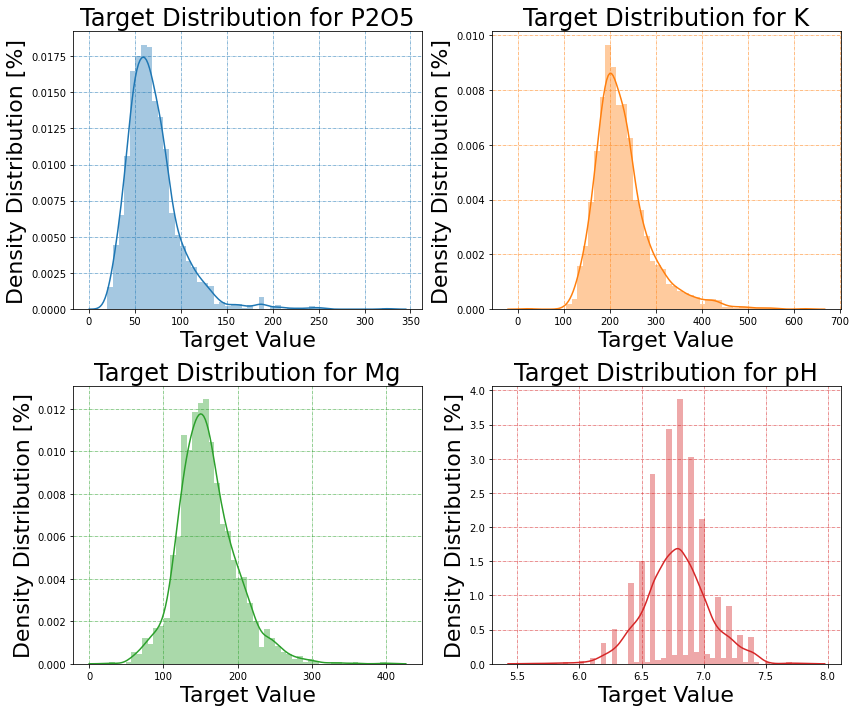

In [220]:
FIG_SIZE=(12,10)
FONT_SIZE=24

density_param = {"density": False}
figs, axs = plt.subplots(2, 2, figsize=FIG_SIZE)

# for i in range(len(cols)):
p1 = sns.distplot(
    y_train[:, 0] * LABEL_MAXS[0],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(0),
    ax=axs[0, 0],
)
axs[0, 0].grid(color="C{}".format(0), linestyle="-.", linewidth=0.5)
axs[0, 0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[0, 0].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[0, 0].set_title("Target Distribution for {}".format(LABEL_NAMES[0]),fontsize=FONT_SIZE)

p1 = sns.distplot(
    y_train[:, 1] * LABEL_MAXS[1],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(1),
    ax=axs[0, 1],
)
axs[0, 1].grid(color="C{}".format(1), linestyle="-.", linewidth=0.5)
axs[0, 1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[0, 1].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[0, 1].set_title("Target Distribution for {}".format(LABEL_NAMES[1]),fontsize=FONT_SIZE)


p1 = sns.distplot(
    y_train[:, 2] * LABEL_MAXS[2],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(2),
    ax=axs[1, 0],
)
axs[1, 0].grid(color="C{}".format(2), linestyle="-.", linewidth=0.5)
axs[1, 0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[1, 0].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[1, 0].set_title("Target Distribution for {}".format(LABEL_NAMES[2]),fontsize=FONT_SIZE)

p1 = sns.distplot(
    y_train[:, 3] * LABEL_MAXS[3],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(3),
    ax=axs[1, 1],
)
axs[1, 1].grid(color="C{}".format(3), linestyle="-.", linewidth=0.5)
axs[1, 1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[1, 1].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[1, 1].set_title("Target Distribution for {}".format(LABEL_NAMES[3]),fontsize=FONT_SIZE)


figs.tight_layout()
#figs.savefig("target_distribution.jpg")
plt.savefig('target_distribution.png')

### 6.B Plot the Field Size distribution for Training and Test Samples

As we realized that data distribution in terms of field size is highly skewed in favor of the small fields. We decided to observe how this unbalance is serious by plotting the histogram of field size distribution as seen below:
    


/p/software/juwels/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/p/software/juwels/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


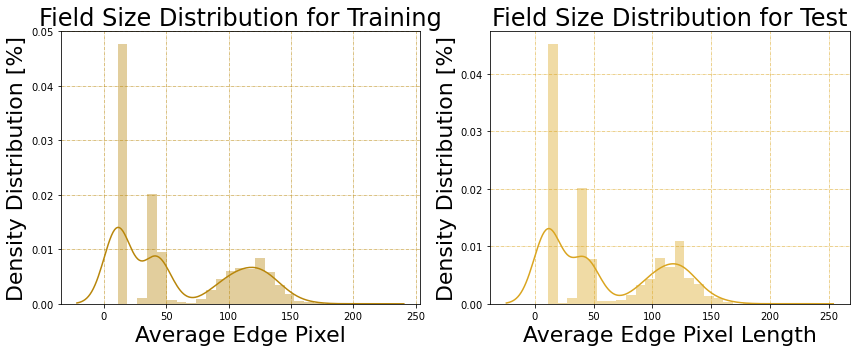

In [192]:
FIG_SIZE=(12,5)
FONT_SIZE=24

density_param = {"density": True}
figs, axss = plt.subplots(1, 2, figsize=FIG_SIZE)
# axss[0].hist(avg_edge_train, bins=50, **density_param)
p0 = sns.distplot(
    avg_edge_train,
    kde=True,
    norm_hist=False,
    bins=25,
    color="darkgoldenrod",
    ax=axss[0],
)
axss[0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axss[0].set_xlabel("Average Edge Pixel",fontsize=FONT_SIZE-2)
axss[0].set_title("Field Size Distribution for Training",fontsize=FONT_SIZE)
axss[0].grid(color="darkgoldenrod", linestyle="-.", linewidth=0.5)

p1 = sns.distplot(
    avg_edge_test, kde=True, norm_hist=False, bins=25, color="goldenrod", ax=axss[1]
)
axss[1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axss[1].set_xlabel("Average Edge Pixel Length",fontsize=FONT_SIZE-2)
axss[1].set_title("Field Size Distribution for Test",fontsize=FONT_SIZE)
axss[1].grid(color="goldenrod", linestyle="-.", linewidth=0.5)

figs.tight_layout()
plt.savefig("field_distribution.png")

### 6.C Plot Feature Importance on Random Forests


In [173]:
feats = {}
#arr, dXdl, d2Xdl2, d3Xdl3, dXds1, s0, s1, s2, s3, s4, reals, imags, cDw2, cAw2
for idx,rf in enumerate(random_forests):
    if idx==0: importances = rf.feature_importances_
    else: importances += rf.feature_importances_
    
imps=[]
for i in range(16):
    #if i==10 or i==11: continue
    imps.append(importances[150*i:150*(i+1)])

imps=np.array(imps)
imp_sum=np.sum(np.array(imps),1)
imp_sum=np.expand_dims(imp_sum/np.sum(imp_sum),1)



feature_names = ['Average reflections over channels', 
                 '1st derivative of avg. reflections',
                 '2nd derivative of avg. reflections', 
                 '3rd derivative of avg. reflections', 
                 'Ratio of 1st & 2nd diagonals of SVD', 
                 '1st principal at diagonal value of SVD', 
                 '2nd principal at diagonal value of SVD', 
                 '3rd principal at diagonal value of SVD', 
                 '4th principal at diagonal value of SVD', 
                 '5th principal at diagonal value of SVD',
                 'Real part of FFT over average reflections', 
                 'Imag part of FFT over average reflections', 
                 'Real part of FFT over 1st & 2nd diag. of SVD', 
                 'Imag part of FFT over 1st & 2nd diag. of SVD', 
                 'Approximation coefficients of wavelet transform', 
                 'Detail coefficients of wavelet transform']

names=pd.DataFrame(np.expand_dims(np.array(feature_names),1),columns=['name'])
feats=np.concatenate([imp_sum, imps],1)

wavelength_path = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/wavelengths.csv'
wavelength_df = pd.read_csv(wavelength_path)
columns=['weight', *wavelength_df['wavelength'].values]

feats = pd.DataFrame(feats,columns=columns)

w_out = pd.concat([names,feats],axis=1)
w_out.head()
w_out=w_out.sort_values(by='weight', ascending=True)

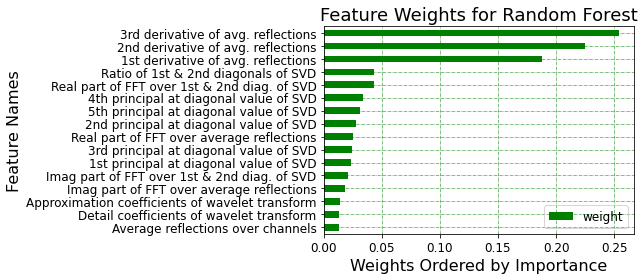

In [225]:
FIG_SIZE=(12,6)
FONT_SIZE=18

w_out[['name', 'weight']].plot(kind="barh",grid=True,x="name",figsize=(9,4),color='g')
plt.rcParams['axes.facecolor'] = 'none'
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Feature Weights for Random Forest",fontsize=FONT_SIZE)
plt.xlabel("Weights Ordered by Importance",fontsize=FONT_SIZE-2)
plt.ylabel("Feature Names",fontsize=FONT_SIZE-2)
plt.tight_layout()
plt.savefig('feature_weights.png')

### 6.D Plot Channel Importance on Random Forests


In [74]:
#w_out.iloc[[0,3,4,5,6,7,8,9,10,11,12,13,14,15]]

/tmp/ipykernel_32620/1027435348.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xticks = np.linspace(0, len(depth_list) - 1, num_ticks, dtype=np.int)


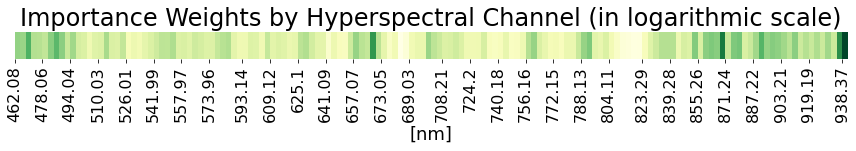

In [160]:

fig, ax = plt.subplots(figsize=(12,2.2))  
depth_list=wavelength_df['wavelength'].values
num_ticks = 30
# the index of the position of yticks
xticks = np.linspace(0, len(depth_list) - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels_list = [depth_list[idx] for idx in xticks]


ax=sns.heatmap(np.expand_dims(np.log(w_out[wavelength_df['wavelength']].iloc[[0,3,4,5,6,7,8,9,10,11,12,13,14,15]].mean()),1).T, yticklabels=False, xticklabels=xticklabels_list,ax=ax,cmap="YlGn",cbar=False,cbar_kws={"orientation": "vertical"})

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels_list,fontsize=16)
ax.set_xlabel("[nm]",fontsize=18)
ax.set_title("Importance Weights by Hyperspectral Channel (in logarithmic scale)",fontsize=24)
plt.tight_layout()
plt.tight_layout()
plt.savefig('channel_weights.png')

### 6.E Plot Prediction vs True Hexabins


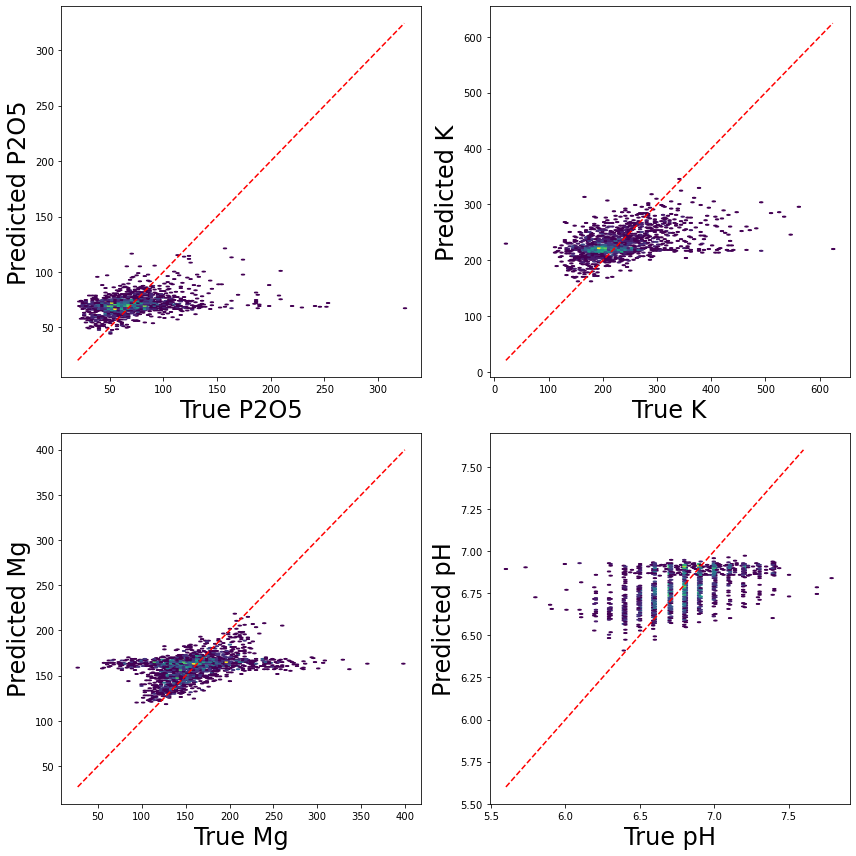

In [123]:
#for y_hat, y_b, y_v, y_e in zip(y_hat_rf_2,y_hat_bl_2, y_v_list_2,edge_v_list_2):
yh1=np.concatenate(y_hat_rf,0)
yv1=np.concatenate(y_v_list_rf,0)
ye1=np.concatenate(edge_v_list_rf,0)  
yh2=np.concatenate(y_hat_knn,0)
yv2=np.concatenate(y_v_list_knn,0)
ye2=np.concatenate(edge_v_list_knn,0)

yh1=yh1[ye1 > 11]
yv1=yv1[ye1 > 11]
yh2=yh2[ye2 <= 11]
yv2=yv2[ye2 <= 11]

FIG_SIZE=(12,12)
FONT_SIZE=24

yv=np.concatenate([yv1,yv2],0)
yh=np.concatenate([yh1,yh2],0)
fig, axs = plt.subplots(2, 2, figsize=FIG_SIZE)

IDX=0
#axs[0,0].set_aspect('equal')
img = axs[0,0].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[0,0].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[0,0].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[0,0].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=1
#axs[0,1].set_aspect('equal')
img = axs[0,1].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[0,1].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[0,1].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[0,1].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=2
#axs[1,0].set_aspect('equal')
img = axs[1,0].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[1,0].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[1,0].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[1,0].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=3
#axs[1,1].set_aspect('equal')
img = axs[1,1].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[1,1].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[1,1].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[1,1].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)




plt.colorbar(img, ax=ax)
plt.tight_layout()
plt.savefig('out_prediction.png')

### 6.F Plot Some of the Features


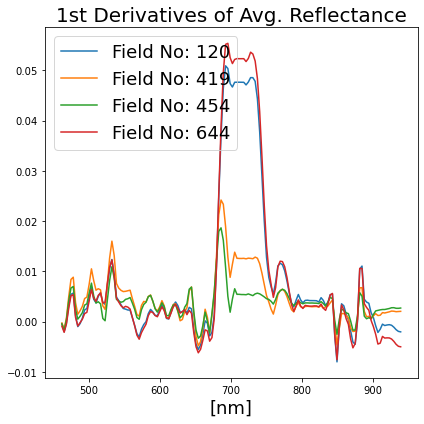

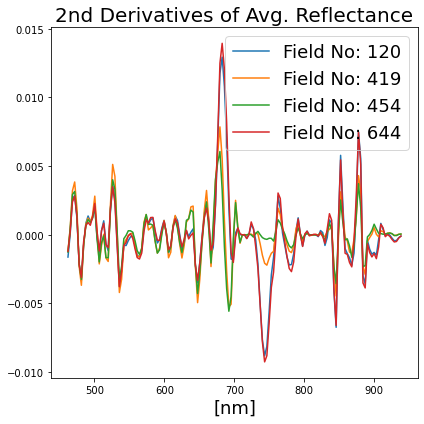

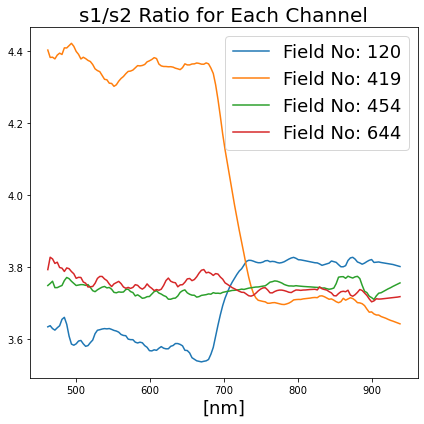

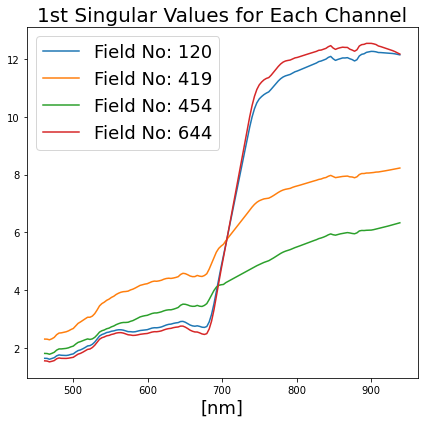

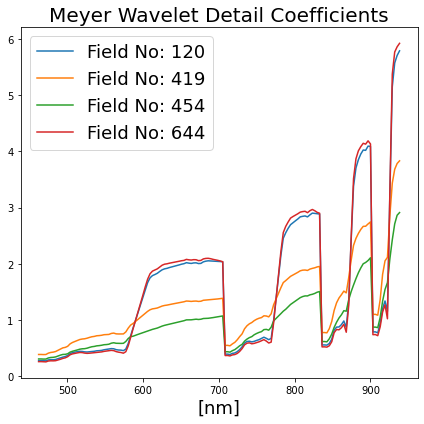

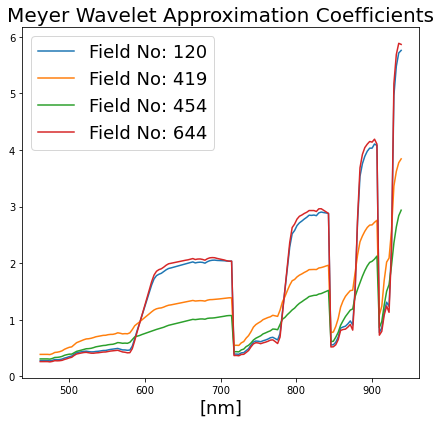

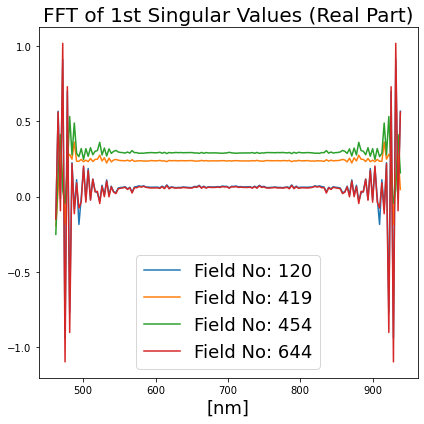

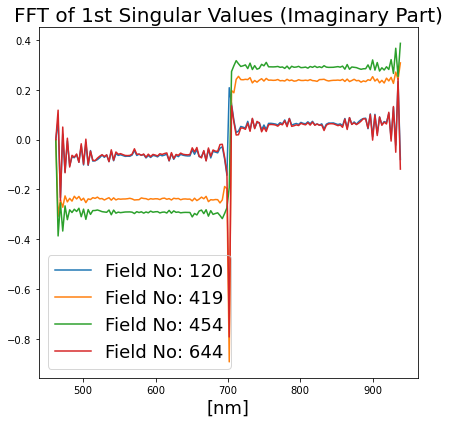

In [120]:
# Feature normalization
X_tr_processed_RF_normalized = np.array(X_tr_processed_RF, copy=True)
for i in range(int(X_tr_processed_RF.shape[-1] / 150)):
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_tr_processed_RF[:, 150 * i : 150 * i + 150])
    
    X_tr_processed_RF_normalized[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_tr_processed_RF[:, 150 * i : 150 * i + 150])
    
FIG_SIZE=(6,6)
FONT_SIZE=20

IDX=np.array([120,419,454,644])
wavelength_path = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/wavelengths.csv'
wavelength_df = pd.read_csv(wavelength_path)

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,150:300], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('1st Derivatives of Avg. Reflectance',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('1st_derivative.png')


fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,300:450], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('2nd Derivatives of Avg. Reflectance',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('2nd_derivative.png')




fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,600:750], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('s1/s2 Ratio for Each Channel',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('s1_s2_ratio.png')



fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,750:900], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('1st Singular Values for Each Channel',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('s1.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,14*150:15*150], label='Field No: {}'.format(i)) #1st-2nd-3rd-4th Coefficients for 
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('Meyer Wavelet Detail Coefficients',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('wavelet_detail.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,15*150:16*150], label='Field No: {}'.format(i)) #1st-2nd-3rd-4th Coefficients for 
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('Meyer Wavelet Approximation Coefficients',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('wavelet_approximation.png')


fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF_normalized[i,12*150:13*150], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('FFT of 1st Singular Values (Real Part)',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('fft_s0_real.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF_normalized[i,13*150:14*150], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('FFT of 1st Singular Values (Imaginary Part)',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('fft_s0_imag.png')